<h2 id="anexoc" style="background-color: #80B8D1 ; color: white; padding: 5px;font-size: 20px;">ANEXO C -  TRANSFORMACIÓN Y SELECCIÓN DE VARIABLES</h2>

### CARGA DE LIBRERÍAS Y DATOS

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import os
from scipy.stats import chi2_contingency
from collections import Counter

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, make_scorer
from sklearn.model_selection import GroupShuffleSplit, RandomizedSearchCV, GroupKFold,cross_val_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.svm import SVR
from sklearn.feature_selection import RFECV

In [2]:
path = "../CMaps/"
train_doc = "train_FD004.txt"
test_doc = "test_FD004.txt"
test_target_doc="RUL_FD004.txt"

indices = ["unit_num", "cycle"]
settings = ["setting_1", "setting_2", "setting_3"]
sensor = ["s_{}".format(i+1) for i in range(0,21)]
col_nombres = indices + settings + sensor

# Leer los datos
train = pd.read_csv((path+train_doc), sep="\s+", header=None, 
                 names=col_nombres)
test = pd.read_csv((path+test_doc), sep="\s+", header=None, 
                 names=col_nombres)
y_test = pd.read_csv((path+test_target_doc), sep="\s+", header=None, 
                 names=["RUL"])

In [3]:
train["setting_1"]=train["setting_1"].round(decimals=1)
train["setting_2"]=train["setting_2"].round(decimals=2)

test["setting_1"]=test["setting_1"].round(decimals=1)
test["setting_2"]=test["setting_2"].round(decimals=2)

### FUNCIÓN AUXILIAR RUL

In [4]:
def RUL_add(dataframe,clipped=False,early=None):
    if "unit_num" in dataframe.columns and "cycle" in dataframe.columns:

        df_rul=dataframe.groupby("unit_num")["cycle"].max().reset_index()
        df_rul.columns=["unit_num","max"]
        dataframe = pd.merge(dataframe, df_rul, on="unit_num")
        dataframe["RUL"]=dataframe["max"]-dataframe["cycle"]
        dataframe=dataframe.drop(labels="max",axis=1)

        if clipped:
             dataframe["RUL"]=dataframe["RUL"].clip(upper=early)

        return dataframe
    else:
        print("El dataframe debe contener las columnas unit_num y cycle")

### MODELO BASE

Previo a adentrarnos en la sección de selección de variables, se estableció un modelo base mediante una regresión lineal. Este modelo inicial sirvió como punto de partida fundamental para orientar las decisiones y estrategias.


Para ello se comenzó imputando la RUL en el conjunto de entrenamiento, y al mismo tiempo se realizó la segregación de la variable objetivo (**y_train**) de las variables predictoras (**X_train**). Cabe destacar que, en el caso de las variables predictoras, se excluyeron las columnas "*unit_num*" y "*cycle*". La primera se trata de una variable de identificación, y la segunda ya fue utilizada previamente para el cálculo de RUL. En el caso del conjunto de prueba, eliminamos las mismas columnas. Además, dentro de **X_test**, solo estamos interesados en el último ciclo de tiempo reportado para cada motor, ya que solo tenemos valores reales de RUL para esos registros (**y_test**).

Por otra parte, se introdujo una variable adicional denominada **groups**, la cual agrupa los valores según el número de motor. Esta variable resultará necesaria para llevar a cabo la validación cruzada, ya que permite que los folds queden estratificados por grupos. En otras palabras, asegura que todos los registros de un mismo motor estén presentes en un solo fold, evitando dispersión de datos entre diferentes pliegues. La preservación de la homogeneidad de los grupos en cada fold asegura que la evaluación sea más precisa y realista, reflejando las condiciones reales en las que el modelo operaría posteriormente en motores individuales.

In [5]:
seed=42

#Train
X_train=RUL_add(train,True,125)
groups=X_train.unit_num #grupos para la validación cruzada

y_train=X_train.RUL
X_train=X_train.drop(labels=["RUL","cycle","unit_num"],axis=1) 

#Test
X_test=test.groupby("unit_num").last().reset_index()
X_test=X_test.drop(labels=["unit_num","cycle"],axis=1)

print(f"Tamaño X_train = {X_train.shape} y Tamaño y_train = {y_train.shape}\nTamaño X_test {X_test.shape} y Tamaño y_test {y_test.shape}")

Tamaño X_train = (61249, 24) y Tamaño y_train = (61249,)
Tamaño X_test (248, 24) y Tamaño y_test (248, 1)


0    125
1    125
2    125
3    125
4    125
Name: RUL, dtype: int64

Ahora si estamos en condiciones de entrenar y evaluar el modelo base. Este proceso se realizó mediante validación cruzada con la técnica de GroupShuffleSplit, que divide los datos en conjuntos de entrenamiento y validación respetando los grupos definidos en *grupos*. Se crean 5 pliegues (15% validación y 85% entrenamiento). Es importante destacar que esta división se realiza sobre el conjunto de entrenamiento, manteniendo el conjunto de prueba intacto para ser utilizado sólo en la evaluación final.  

Como métrica de evaluación se optó por el RMSE (Root Mean Square Error). El objetivo principal es predecir con la mayor precisión posible la RUL de los motores. Si bien tanto el MSE como el RMSE se enfocan en penalizar los errores mayores, evitando pronósticos significativamente incorrectos en el ámbito de mantenimiento, el RMSE tiene la ventaja de ser intuitivo y más fácil de interpretar.


In [9]:
model = LinearRegression()

#Se evalúa el modelo 
gss = GroupShuffleSplit(n_splits=5, test_size=0.15, random_state=seed)
scores = cross_val_score(model, X_train, y_train, groups=groups, cv=gss,scoring="neg_root_mean_squared_error")

print ("RSME:", -scores.round(2))
print("RSME: ", -scores.mean().round(2),"Desviación estándar: ", scores.std().round(2))


RSME: [23.72 21.96 21.95 20.83 21.54]
RSME:  22.0 Desviación estándar:  0.95


Por tanto, el **RMSE** obtenido con el **modelo base es de 22** (condiciónes: GroupShuffleSplit 15% val size y 5 folds).

### TRANSFORMACIONES INICIALES

**VARIABLES CATEGÓRICAS**

Dado que las variables categóricas (setting_1, setting_2 y setting_3) tienen un número limitado de categorías, se optó por transformarlas en variables dummy utilizando codificación one-hot, ya que esto no incrementa de manera significativa la cantidad de características.

In [10]:
X_train=pd.get_dummies(data=X_train,columns=settings)
X_test=pd.get_dummies(data=X_test,columns=settings)

In [11]:
print(f"Tamaño X_train = {X_train.shape} y Tamaño y_train = {y_train.shape}\nTamaño X_test {X_test.shape} y Tamaño y_test {y_test.shape}")

X_train.columns

Tamaño X_train = (61249, 34) y Tamaño y_train = (61249,)
Tamaño X_test (248, 34) y Tamaño y_test (248, 1)


Index(['s_1', 's_2', 's_3', 's_4', 's_5', 's_6', 's_7', 's_8', 's_9', 's_10',
       's_11', 's_12', 's_13', 's_14', 's_15', 's_16', 's_17', 's_18', 's_19',
       's_20', 's_21', 'setting_1_0.0', 'setting_1_10.0', 'setting_1_20.0',
       'setting_1_25.0', 'setting_1_35.0', 'setting_1_42.0', 'setting_2_0.0',
       'setting_2_0.25', 'setting_2_0.62', 'setting_2_0.7', 'setting_2_0.84',
       'setting_3_60.0', 'setting_3_100.0'],
      dtype='object')

**VARIABLES NUMÉRICAS**

El escalado es necesario para muchos algoritmos (aunque no todos) debido a que pueden verse influenciados por las disparidades de escala. Es decir, para evitar que variables con valores más grandes pueden tener un impacto desproporcionado en el modelo. Dado que en esta sección se probarán varios modelos se procedió a escalar las variables numéricas.
Como se vio en la sección de EDA, las variables numéricas tienen diferentes distribuciones según la condición operativa del sistema. Por ello se optó por probar dos enfoques, un *escalado globa*l y un *escalado por condición operativa*. Se compararán ambos enfoques para determinar cuál mejora más la capacidad predictiva.


**Escalado Global**

In [12]:
scaler = MinMaxScaler()
scaler.fit(X_train[sensor])
X_train[sensor] = scaler.transform(X_train[sensor])
X_test[sensor] = scaler.transform(X_test[sensor])

In [13]:
model = LinearRegression()

group_shuffle_split = GroupShuffleSplit(n_splits=5, test_size=0.15, random_state=seed)

scores = cross_val_score(model, X_train, y_train, groups=groups, cv=group_shuffle_split,scoring="neg_root_mean_squared_error")

print ("RSME:", -scores.round(2))
print("RSME: ", -scores.mean().round(2),"Desviación estándar: ", scores.std().round(2))


RSME: [23.72 21.96 21.95 20.83 21.54]
RSME:  22.0 Desviación estándar:  0.95


**Escalado por condición operativa**

In [14]:
seed=42

#Train
X_train=RUL_add(train,True,125)
groups=X_train.unit_num 

y_train=X_train.RUL
X_train=X_train.drop(labels=["RUL","cycle","unit_num"],axis=1) 

#Test
X_test=test.groupby("unit_num").last().reset_index()
X_test=X_test.drop(labels=["unit_num","cycle"],axis=1)

In [15]:
#Se crea variable condición operativa
X_train["condición_op"] = X_train["setting_1"].astype(str) + "_" + \
                        X_train["setting_2"].astype(str) + "_" + \
                        X_train["setting_3"].astype(str)

X_test["condición_op"] = X_test["setting_1"].astype(str) + "_" + \
                        X_test["setting_2"].astype(str) + "_" + \
                        X_test["setting_3"].astype(str)

#Escalado por condición operativa

for cond in X_train["condición_op"].unique(): 
    filtro=X_train[X_train["condición_op"]==cond]
    filtro_test=X_test[X_test["condición_op"]==cond]
    scaler = MinMaxScaler()
    scaler.fit(filtro[sensor])
    X_train.loc[X_train["condición_op"]==cond, sensor]=scaler.transform(filtro[sensor])
    X_test.loc[X_test["condición_op"]==cond, sensor]=scaler.transform(filtro_test[sensor])

#Luego de escalar se elimina variable creada "condición_op"
X_train=X_train.drop(labels="condición_op",axis=1)
X_test=X_test.drop(labels="condición_op",axis=1)

#Dummies variables setting
X_train=pd.get_dummies(data=X_train,columns=settings)
X_test=pd.get_dummies(data=X_test,columns=settings)

In [16]:
model = LinearRegression()

group_shuffle_split = GroupShuffleSplit(n_splits=5, test_size=0.15, random_state=seed)

scores = cross_val_score(model, X_train, y_train, groups=groups, cv=group_shuffle_split,scoring="neg_root_mean_squared_error")

print ("RSME:", -scores.round(2))
print("RSME: ", -scores.mean().round(2),"Desviación estándar: ", scores.std().round(2))


RSME: [23.49 21.61 21.52 20.52 21.23]
RSME:  21.67 Desviación estándar:  0.99


Dado que se obtuvieron mejores resultados con el escalado por condición operativa se continuará con esta opción (RMSE 21.67 vs 22.00).

**VARIABLES CATEGÓRICAS - OTRO ENFOQUE**  

En cuanto al tratamiento de variables categóricas, hasta ahora se ha empleado la técnica de codificación one-hot para las tres variables en cuestión. Sin embargo, dado que estas variables se combinan de manera exclusiva en tan solo seis condiciones operativas distintas, se explorará el impacto de crear una sola variable que represente la condición operativa. Posteriormente, esta variable será transformada en variables dummies. Esta estrategia también conlleva la ventaja de reducir la cantidad total de variables del conjunto de datos.

In [17]:
seed=42

#Train
X_train=RUL_add(train,True,125)
groups=X_train.unit_num

y_train=X_train.RUL
X_train=X_train.drop(labels=["RUL","cycle","unit_num"],axis=1) 

#Test
X_test=test.groupby("unit_num").last().reset_index()
X_test=X_test.drop(labels=["unit_num","cycle"],axis=1)

#Se crea variable condición operativa
X_train["condición_op"] = X_train["setting_1"].astype(str) + "_" + \
                        X_train["setting_2"].astype(str) + "_" + \
                        X_train["setting_3"].astype(str)

X_test["condición_op"] = X_test["setting_1"].astype(str) + "_" + \
                        X_test["setting_2"].astype(str) + "_" + \
                        X_test["setting_3"].astype(str)
#Escalado por condición operativa

for cond in X_train["condición_op"].unique(): 
    filtro=X_train[X_train["condición_op"]==cond]
    filtro_test=X_test[X_test["condición_op"]==cond]
    scaler = MinMaxScaler()
    scaler.fit(filtro[sensor])
    X_train.loc[X_train["condición_op"]==cond, sensor]=scaler.transform(filtro[sensor])
    X_test.loc[X_test["condición_op"]==cond, sensor]=scaler.transform(filtro_test[sensor])
    
#Se eliminan las 3 variables setting y se crean variables dummies para la variable condición operativa
X_train=X_train.drop(labels=settings,axis=1)
X_test=X_test.drop(labels=settings,axis=1)

X_train=pd.get_dummies(data=X_train,columns=["condición_op"])
X_test=pd.get_dummies(data=X_test,columns=["condición_op"])

print(f"Tamaño X_train = {X_train.shape} y Tamaño y_train = {y_train.shape}\nTamaño X_test {X_test.shape} y Tamaño y_test {y_test.shape}")
X_train.columns

Tamaño X_train = (61249, 27) y Tamaño y_train = (61249,)
Tamaño X_test (248, 27) y Tamaño y_test (248, 1)


Index(['s_1', 's_2', 's_3', 's_4', 's_5', 's_6', 's_7', 's_8', 's_9', 's_10',
       's_11', 's_12', 's_13', 's_14', 's_15', 's_16', 's_17', 's_18', 's_19',
       's_20', 's_21', 'condición_op_0.0_0.0_100.0',
       'condición_op_10.0_0.25_100.0', 'condición_op_20.0_0.7_100.0',
       'condición_op_25.0_0.62_60.0', 'condición_op_35.0_0.84_100.0',
       'condición_op_42.0_0.84_100.0'],
      dtype='object')

In [18]:
model = LinearRegression()

group_shuffle_split = GroupShuffleSplit(n_splits=5, test_size=0.15, random_state=seed)

scores = cross_val_score(model, X_train, y_train, groups=groups, cv=group_shuffle_split,scoring="neg_root_mean_squared_error")

print ("RSME:", -scores.round(2))
print("RSME: ", -scores.mean().round(2),"Desviación estándar: ", scores.std().round(2))

RSME: [23.48 21.61 21.52 20.52 21.23]
RSME:  21.67 Desviación estándar:  0.98


Como podemos ver arroja el mismo resultado que el escenario anterior (RMSE 21.67). Sin embargo, en este escenario hemos reducido de 34 a 27 las variables. Por tanto, se continúa con la opción de trabajar con una única variable categórica pasada a dummies que resume la condición operativa del equipo.

### SELECCIÓN DE VARIABLES

Para dar inicio a la selección de variables se optó por trabajar con un método wrapper, en particular con la *Eliminación Recursiva de Características (RFE)*. La RFE es un proceso iterativo que comienza con todas las variables y, en cada iteración, elimina aquella que se considera menos relevantes. A su vez, para hacer el proceso más robusto se utilizó validación cruzada (RFECV).

In [72]:
model=LinearRegression()
cv = GroupShuffleSplit(n_splits=5, test_size=0.15, random_state=seed)

rfe= RFECV(estimator=model,cv=cv,scoring="neg_root_mean_squared_error")
results=rfe.fit(X_train, y_train,groups=groups)

print(f"Número optimo de features: {rfe.n_features_}")
X_train.columns[~results.support_]

Número optimo de features: 27


Index([], dtype='object')

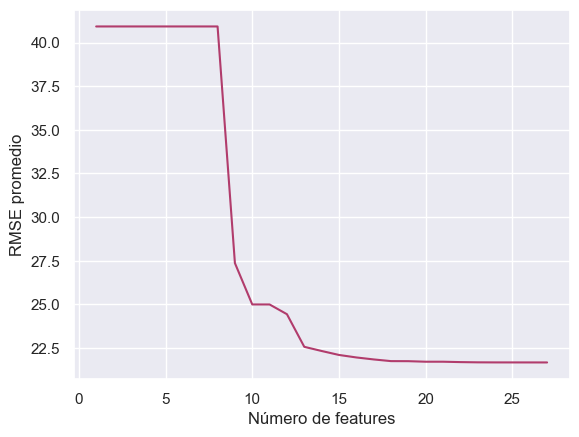

In [73]:
# Graficar el número de variables vs RMSE promedio
num_features = range(1, len(results.cv_results_["mean_test_score"]) + 1)
mean_scores = results.cv_results_["mean_test_score"]

plt.plot(num_features, -mean_scores,color=sns.color_palette("flare")[3])
plt.xlabel("Número de features")
plt.ylabel("RMSE promedio")
plt.show()

De acuerdo con el resultado de la RFE el número óptimo de variables coincide con las variables totales: 27. Sin embargo si graficamos los resultados se observa claramente que luego de un punto la mejora obtenida adicionando más variables se vuelve muy pequeña. Para seguir profundizando se repitió el procedimiento de Eliminación Recursiva de variables con diferentes semillas:

In [74]:
model = LinearRegression()

# Se repite el proceo con diferentes semillas
num_repeats = 20
selected_features_list = []
rejected_features_list = []

for i in range(num_repeats):

    # Crear instancia de GroupShuffleSplit con semilla actual
    cv = GroupShuffleSplit(n_splits=5, test_size=0.15, random_state=seed+i*1000)
    rfe = RFECV(estimator=model, cv=cv, scoring="neg_root_mean_squared_error")

    #Realziar el proceso de RFECV:
    results = rfe.fit(X_train, y_train, groups=groups)
    selected_features = X_train.columns[results.support_]
    rejected_features = X_train.columns[~results.support_]
    selected_features_list.append(selected_features)
    rejected_features_list.append(rejected_features)

#Se visualizan los resultados: 
for i in range(num_repeats):
    print(f"Repetición {i+1}:")


    print("Variables rechazadas:")
    for feature in rejected_features_list[i]:
        print(feature)

Repetición 1:
Variables rechazadas:
Repetición 2:
Variables rechazadas:
Repetición 3:
Variables rechazadas:
Repetición 4:
Variables rechazadas:
Repetición 5:
Variables rechazadas:
Repetición 6:
Variables rechazadas:
Repetición 7:
Variables rechazadas:
Repetición 8:
Variables rechazadas:
Repetición 9:
Variables rechazadas:
Repetición 10:
Variables rechazadas:
Repetición 11:
Variables rechazadas:
Repetición 12:
Variables rechazadas:
Repetición 13:
Variables rechazadas:
s_10
Repetición 14:
Variables rechazadas:
s_10
Repetición 15:
Variables rechazadas:
Repetición 16:
Variables rechazadas:
Repetición 17:
Variables rechazadas:
Repetición 18:
Variables rechazadas:
Repetición 19:
Variables rechazadas:
s_10
Repetición 20:
Variables rechazadas:
s_10


In [75]:
#Se crea tabla de frencuancia para los resultados de las 20 repeticiones:
frecuencia = Counter(tuple(sublista) for sublista in rejected_features_list)
tabla_frecuencia = pd.DataFrame.from_dict(frecuencia, orient="index", columns=["Frecuencia"])
tabla_frecuencia.index = tabla_frecuencia.index.map(list)

print(tabla_frecuencia)

        Frecuencia
[]              16
[s_10]           4


Luego de repetir el procedimiento con varias semillas vemos que en algunos casos sugiere la eliminación de la variable *s_10*. Se analizará entonces el efecto de eliminar dicha variable.  A su vez, según se detectó previamente, existen variables que están completamente determinadas por la condición operativa del sistema y que por tanto no agregarían información adicional al modelo. Incluirlas como predictoras no sería beneficioso y podría aumentar la complejidad innecesariamente.

Lo anterior se visualiza en la siguiente tabla, donde los sensores s_1,s_5,s_18 y s_19 no tienen variación alguna luego de estandarizar por condición:

In [80]:
X_train[sensor].describe()

,s_1,s_2,s_3,s_4,s_5,s_6,s_7,s_8,s_9,s_10,...,s_12,s_13,s_14,s_15,s_16,s_17,s_18,s_19,s_20,s_21
count,61249.0,61249.000000,61249.000000,61249.000000,61249.0,61249.000000,61249.000000,61249.000000,61249.000000,61249.000000,...,61249.000000,61249.000000,61249.000000,61249.000000,61249.000000,61249.000000,61249.0,61249.0,61249.000000,61249.000000
mean,0.0,0.452780,0.456710,0.450130,0.0,0.747892,0.325508,0.366669,0.233626,0.325457,...,0.316979,0.368822,0.265071,0.578291,0.174419,0.455573,0.0,0.0,0.462361,0.465415
std,0.0,0.142170,0.143998,0.159512,0.0,0.229653,0.148305,0.168859,0.106963,0.157175,...,0.148988,0.175213,0.099790,0.154062,0.379473,0.156207,0.0,0.0,0.133552,0.135428
min,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000
25%,0.0,0.352239,0.355853,0.333399,0.0,0.600000,0.228496,0.254098,0.164702,0.200000,...,0.226804,0.253906,0.200505,0.494503,0.000000,0.363636,0.0,0.0,0.373737,0.375603
50%,0.0,0.441860,0.448547,0.435434,0.0,0.818182,0.302564,0.318471,0.211594,0.333333,...,0.287172,0.319672,0.245386,0.596868,0.000000,0.454545,0.0,0.0,0.458333,0.461340
75%,0.0,0.543605,0.550670,0.552065,0.0,0.909091,0.375641,0.426230,0.271548,0.400000,...,0.359450,0.424920,0.302596,0.680556,0.000000,0.545455,0.0,0.0,0.546296,0.550475
max,0.0,1.000000,1.000000,1.000000,0.0,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.0,0.0,1.000000,1.000000


En este punto, para que la toma de decisiones en lo referente a selección de variables sea lo más robusta posible, se trabajó con un enfoque de validación cruzada repetida. Es decir, no solo se aplica validación cruzada estándar, sino que también se realizan múltiples repeticiones, permitiendo diferentes particiones aleatorias de los datos en cada iteración. De esta forma se obtendrá una evaluación más sólida.

Para lograr esto se creó una función con tal propósito, que podrá aplicarse a cualquier modelo, no solo a una Regresión Lineal.


In [76]:
def Group_Shuffle_Split_repetido(model,X_train,y_train,n_splits,test_size,groups,seed,n_repeats):
    scores = []

    for repeat in range(n_repeats):
        #Generar una semilla única para cada repetición
        seed_repeat = seed + repeat
        #Generar los diferentes splits
        group_shuffle_split = GroupShuffleSplit(n_splits=n_splits, test_size=test_size, random_state=seed_repeat)

        for train_index, test_index in group_shuffle_split.split(X_train, y_train, groups=groups):
            X_train_fold, X_test_fold = X_train.iloc[train_index], X_train.iloc[test_index]
            y_train_fold, y_test_fold = y_train.iloc[train_index], y_train.iloc[test_index]
        
            #Entrenar y evaluar el modelo. 
            model.fit(X_train_fold, y_train_fold)
            y_pred = model.predict(X_test_fold)
            score = mean_squared_error(y_test_fold, y_pred, squared=False) #Calcular RMSE
            #almacenar los resultados 
            scores.append(score.round(2))

    scores = np.array(scores)
    return scores

Se procede a comparar el resultado de un modelo de regresión lineal con:
- Todas las variables (score_0)
- Todas las variables menos el sensor_10 recomendado por RFE (score_1)
- Todas las variables menos sensores 1, 5, 18 y 19 (score_2)
- Todas las variables menos sensores 1, 5, 10, 18 y 19 (score_3)

In [77]:
model = LinearRegression()
n_splits = 5  #Número de splits en cada repetición
n_repeats = 10  #Número de repeticiones
test_size = 0.15  #Tamaño de la muestra de prueba en cada split
seed = seed  #semilla inicial

#Resultados dejando todas las variables
scores_0=Group_Shuffle_Split_repetido(model,X_train,y_train,n_splits,test_size,groups,seed,n_repeats)


#Resultado eliminando los siguientes conjuntos de variables 
variables_a_eliminar = [["s_10"],
                        ["s_1", "s_5", "s_18", "s_19"],
                        ["s_1", "s_5", "s_18", "s_19","s_10"]]

resultados = {}

for i, var in enumerate(variables_a_eliminar):
    nombre_variable = f"score_{i+1}"
    resultados[nombre_variable] = Group_Shuffle_Split_repetido(model, X_train.drop(var, axis=1), y_train, n_splits, test_size, groups, seed, n_repeats)


<AxesSubplot: >

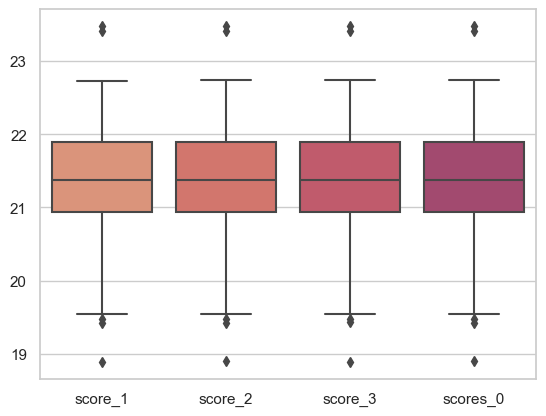

In [83]:
resultados=pd.DataFrame(resultados)
resultados["scores_0"]=scores_0
sns.set(style="whitegrid", palette="flare")
sns.boxplot(data=resultados)

In [85]:
resultados.mean()

score_1     21.3338
score_2     21.3336
score_3     21.3348
scores_0    21.3334
dtype: float64

Como podemos ver la eliminación de dichas variables no empeora los resultados obtenidos. Antes de proceder a su eliminación, se repitió el mismo procedimiento, pero con un modelo más complejo y flexible como es el Random Forest. Este modelo puede capturar relaciones no lineales e interacciones entre variables de manera más efectiva que la regresión lineal. La idea es combinar ambos enfoques para tener una visión más completa sobre el impacto de las diferentes variables y por tanto tomar decisiones más sólidas en cuanto a la selección de features. A su vez, se considera pertinente ya que, dada la naturaleza de los datos, se espera la existencia de relaciones no lineales.

<AxesSubplot: >

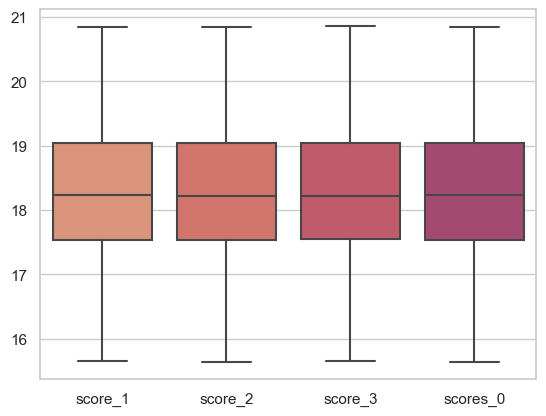

In [79]:
model = RandomForestRegressor(random_state=seed,n_jobs=-1)
n_splits = 5  
n_repeats = 10
test_size = 0.15
seed = seed

#Resultados dejando todas las variables
scores_0=Group_Shuffle_Split_repetido(model,X_train,y_train,n_splits,test_size,groups,seed,n_repeats)


#Resultado eliminando los siguientes conjuntos de variables 
variables_a_eliminar = [["s_10"],
                        ["s_1", "s_5", "s_18", "s_19"],
                        ["s_1", "s_5", "s_18", "s_19","s_10"]]

resultados_RF = {} 

for i, var in enumerate(variables_a_eliminar):
    nombre_variable = f"score_{i+1}"
    resultados_RF[nombre_variable] = Group_Shuffle_Split_repetido(model, X_train.drop(var, axis=1), y_train, n_splits, test_size, groups, seed, n_repeats)

resultados_RF=pd.DataFrame(resultados_RF)
resultados_RF["scores_0"]=scores_0
sns.set(style="whitegrid", palette="flare")
sns.boxplot(data=resultados_RF)

In [80]:
resultados_RF.mean()

score_1     18.2762
score_2     18.2724
score_3     18.2714
scores_0    18.2742
dtype: float64

Nuevamente, la eliminación de las variables no empeora el resultado obtenido. Avanzamos entonces quitando esos 5 sensores: 1,5,10,18 y 19

In [19]:
sensores_a_eliminar = ["s_1", "s_5", "s_18", "s_19","s_10"]
X_train=X_train.drop(labels=sensores_a_eliminar,axis=1)
X_test=X_test.drop(labels=sensores_a_eliminar,axis=1)

sensor = list(set(sensor) - set(sensores_a_eliminar))

### INGENIERÍA DE VARIABLES

Una técnica de ingeniería de características muy útil es crear combinaciones polinomiales de las variables, las cuales pueden revelar patrones en los datos que no son evidentes a partir de las características originales. En este caso se crearon nuevas variables con combinaciones polinomiales de segundo grado ([a, b] -> [1, a, b, a^2, ab, b^2]). 

In [102]:
poly = PolynomialFeatures(2,interaction_only=False)

X_train_transformed= poly.fit_transform(X_train[sensor])
X_test_transformed = poly.fit_transform(X_test[sensor])

col_nombres = poly.get_feature_names_out()
X_train_transformed = pd.DataFrame(X_train_transformed, columns=col_nombres)
X_test_transformed = pd.DataFrame(X_test_transformed, columns=col_nombres)

In [103]:
settings=["condición_op_0.0_0.0_100.0", "condición_op_10.0_0.25_100.0",
         "condición_op_20.0_0.7_100.0", "condición_op_25.0_0.62_60.0",
         "condición_op_35.0_0.84_100.0", "condición_op_42.0_0.84_100.0"]

X_train_transformed=pd.concat([X_train_transformed,X_train[settings]],axis=1)
X_test_transformed=pd.concat([X_test_transformed,X_test[settings]],axis=1)

print(f"X_train: {X_train.shape}")
print(f"X_test:{X_test.shape}")
print(f"X_train_transfomed: {X_train_transformed.shape}")
print("{X_test_transformed.shape}")

X_train_transformed.head()

X_train: (61249, 22)
X_test:(248, 22)
X_train_transfomed: (61249, 159)
{X_test_transformed.shape}


,1,s_17,s_21,s_9,s_14,s_4,s_15,s_6,s_2,s_20,...,s_13 s_16,s_7^2,s_7 s_16,s_16^2,condición_op_0.0_0.0_100.0,condición_op_10.0_0.25_100.0,condición_op_20.0_0.7_100.0,condición_op_25.0_0.62_60.0,condición_op_35.0_0.84_100.0,condición_op_42.0_0.84_100.0
0,1.0,0.363636,0.473138,0.141023,0.175935,0.278866,0.602638,0.600000,0.500000,0.460000,...,0.0,0.023276,0.0,0.0,0,0,0,0,0,1
1,1.0,0.090909,0.380397,0.133347,0.115529,0.217594,0.577645,0.454545,0.113433,0.297710,...,0.0,0.024426,0.0,0.0,0,0,1,0,0,0
2,1.0,0.272727,0.564017,0.113508,0.125431,0.349656,0.741138,0.400000,0.287791,0.320000,...,0.0,0.066405,0.0,0.0,0,0,0,0,0,1
3,1.0,0.181818,0.557824,0.147144,0.183440,0.366495,0.609646,0.600000,0.215116,0.380000,...,0.0,0.053848,0.0,0.0,0,0,0,0,0,1
4,1.0,0.333333,0.625683,0.086859,0.171331,0.181548,0.507187,0.400000,0.220641,0.222222,...,0.0,0.056509,0.0,0.0,0,0,0,1,0,0


La transformación anterior conduce a un aumento significativo de la cantidad de variables, pasando de 22 a 159, con un consecuente aumento en la complejidad del modelo. Para evitar esto se seleccionan solo aquellas variables transformadas más significativas. Lo anterior se llevó a cabo utilizando SelectKBest para seleccionar las k mejores variables en función de cuánta información mutua proporcionan para predecir la variable objetivo. La función mutual_info_regression calcula cuánta información comparten las características con el objetivo. El proceso ayuda a identificar las variables más relevantes para mejorar el rendimiento del modelo de regresión al enfocarse en las relaciones más informativas entre las variables y el objetivo.

In [104]:
test=SelectKBest(score_func= mutual_info_regression)
result=test.fit(X_train_transformed,y_train)

#Ver las 10 mejores
PD_Results=pd.DataFrame(zip(X_train_transformed.columns,result.scores_),columns=("variable","score"))
pd.set_option("display.max_rows", None)
print(PD_Results.sort_values("score",ascending=False).head(10))

      variable     score
82    s_4 s_11  0.464396
28   s_17 s_11  0.462659
139   s_11 s_3  0.449256
12        s_11  0.441310
138     s_11^2  0.438658
57    s_9 s_11  0.430493
87      s_15^2  0.417234
21    s_17 s_4  0.416818
6         s_15  0.416234
83     s_4 s_3  0.414953


Se seleccionan las primeras 5 variables *transformadas* y se adicionan al conjunto de datos de entrenamiento: 

In [106]:
X_train["s_4 s_11"]=X_train_transformed["s_4 s_11"]
X_train["s_17 s_11"]=X_train_transformed["s_17 s_11"]
X_train["s_11 s_3"]=X_train_transformed["s_11 s_3"]
X_train["s_11^2"]=X_train_transformed["s_11^2"]
X_train["s_9 s_11"]=X_train_transformed["s_9 s_11"]

A continuación, se evalúa el resultado de la adición de estas 5 variables, utilizando  el mismo esquema de trabajo que se utilizó anteriormente (5 splits, val_size 15% y 10 repeticiones). De igual forma, se realizó con un modelo de regresión lineal y un modelo tipo Random Forest. 

<AxesSubplot: >

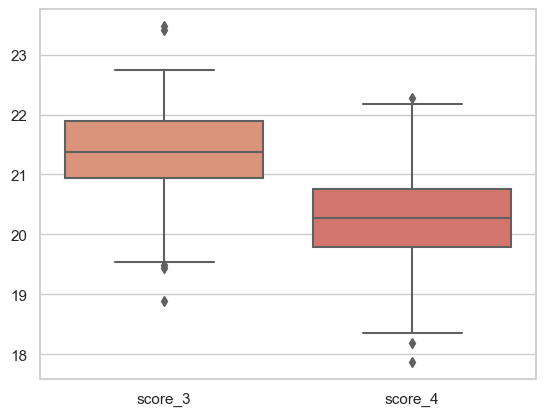

In [117]:
model = LinearRegression()
n_splits = 5  
n_repeats = 10  
test_size = 0.15  
seed = seed 

#Resultados agregando esas 5 variables
score_4=Group_Shuffle_Split_repetido(model,X_train,y_train,n_splits,test_size,groups,seed,n_repeats) 

resultados["score_4"]=score_4
sns.set(style="whitegrid", palette="flare")
sns.boxplot(data=resultados[["score_3","score_4"]])

Recordando en *score_3* tenemos almacenados los resultados tras hacer una validación cruzada repetida con las variables seleccionadas hasta el momento (todas menos sensores 1, 5, 10, 18 y 19). Como se puede ver en el gráfico, al agregar esas 5 variables obtenemos una mejora significativa. Lo anterior era de esperarse puesto que le permite a la regresión lineal capturar relaciones no lineales. Nuevamente, volvemos a analizar los resultados, pero utilizando un modelo tipo Random Forest para tener una visión más global del impacto que se está evaluando.

<AxesSubplot: >

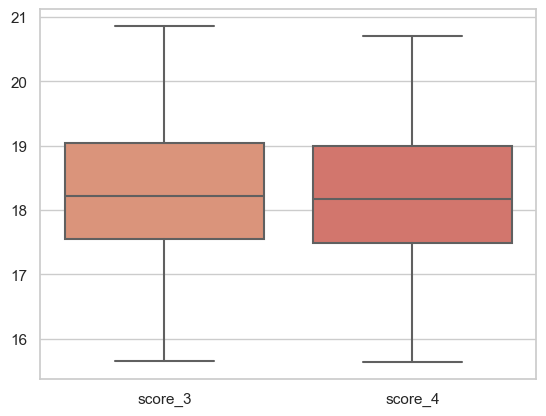

In [115]:
model = RandomForestRegressor(n_jobs=-1)
n_splits = 5  
n_repeats = 10  
test_size = 0.15 
seed = seed  

#Resultados agregando esas 5 variables
score_4=Group_Shuffle_Split_repetido(model,X_train,y_train,n_splits,test_size,groups,seed,n_repeats) 

resultados_RF["score_4"]=score_4
sns.set(style="whitegrid", palette="flare")
sns.boxplot(data=resultados_RF[["score_3","score_4"]])

En este caso, a diferencia del anterior, no se observa una mejora significativa al adicionar las variables transformadas. La razón detrás de lo mencionado podría atribuirse al hecho de que en un modelo lineal se hace más necesario capturar otras relaciones cuando la naturaleza de la problema es justamente no lineal. Sin embargo, otros algoritmos más complejos, tienen la capacidad inherente de capturar relaciones no lineales sin la necesidad de agregar términos polinómicos explícitos, haciendo que no sea necesario adicionar estas transformaciones. 

In [122]:
columnas = ["s_4 s_11", "s_17 s_11", "s_11 s_3", "s_11^2", "s_9 s_11"]
X_train=X_train.drop(labels=columnas,axis=1)
X_train.head()

,s_2,s_3,s_4,s_6,s_7,s_8,s_9,s_11,s_12,s_13,...,s_16,s_17,s_20,s_21,condición_op_0.0_0.0_100.0,condición_op_10.0_0.25_100.0,condición_op_20.0_0.7_100.0,condición_op_25.0_0.62_60.0,condición_op_35.0_0.84_100.0,condición_op_42.0_0.84_100.0
0,0.500000,0.255293,0.278866,0.600000,0.152564,0.283276,0.141023,0.261905,0.206171,0.307937,...,0.0,0.363636,0.460000,0.473138,0,0,0,0,0,1
1,0.113433,0.335117,0.217594,0.454545,0.156289,0.114650,0.133347,0.241935,0.114089,0.059603,...,0.0,0.090909,0.297710,0.380397,0,0,1,0,0,0
2,0.287791,0.249042,0.349656,0.400000,0.257692,0.303754,0.113508,0.244048,0.183731,0.301587,...,0.0,0.272727,0.320000,0.564017,0,0,0,0,0,1
3,0.215116,0.211131,0.366495,0.600000,0.232051,0.290102,0.147144,0.255952,0.208976,0.317460,...,0.0,0.181818,0.380000,0.557824,0,0,0,0,0,1
4,0.220641,0.320654,0.181548,0.400000,0.237716,0.204918,0.086859,0.283871,0.230321,0.199219,...,0.0,0.333333,0.222222,0.625683,0,0,0,1,0,0


In [1]:
from IPython.core.display import HTML, display

style = """
<style>
div.output_area {
    max-height: 500px; 
}

.rendered_html p {
    text-align: justify;
    font-size: 13px;
}

.rendered_html ul li, .rendered_html ol li {
    font-size: 13px;
}

.rendered_html h2#eda {
    background-color: #80B8D1;
    color: white;
    padding: 10px;
    font-size: 18px;
}
</style>
"""

display(HTML(style))